## **Notlar**

🎯 1. Sınıf Dengesizliği Azaltma
Veri setindeki bazı pitch (nota) sınıfları çok daha az görünüyor.

BCEWithLogitsLoss(pos_weight=...) kullanılarak az görülen sınıflara ağırlık verilebilir.

Alternatif: Focal Loss kullanarak nadir sınıfları vurgulamak.

🧠 2. Model Mimarisi Derinleştirme
Şu an sadece CNN kullanılıyor.

CNN + BiLSTM (CRNN) mimarisi kullanılarak zaman bağımlılıkları daha iyi öğrenilebilir.

Özellikle arka arkaya çalınan benzer pitch'lerin ayırt edilmesinde fayda sağlar.

🔀 3. Data Augmentation (Veri Çoğaltma)
Melspectrogram seviyesinde pitch shift, time stretch gibi augmentasyonlar uygulanabilir.

Overfitting riski azaltılır, modelin genelleme yeteneği artar.

🧪 4. Gerçek Test Seti Ayrımı
Mevcut yapı train/val (örn. %80/%20) ayırımı yapıyor.

%80 train / %10 val / %10 test olarak ayırmak, daha gerçekçi başarı ölçümü sağlar.

Test set, model eğitimi tamamlandıktan sonra sadece değerlendirme için kullanılır.

📊 5. Yeni Metrikler: ROC-AUC, Hamming Score
ROC-AUC, sınıf başına karar kalitesini gösterir.

hamming_score gibi alternatif metriklerle modelin başarısı daha geniş ölçekte değerlendirilebilir.

🧱 6. Threshold Tuning
Şu an 0.5 threshold sabit kullanılıyor.

Her pitch için en uygun threshold değeri grid search ile bulunabilir.

Precision/Recall dengesini doğrudan etkiler.

🎧 7. Ses Rekonstrüksiyonu (Audio Inverse)
Modelin çıktısına göre tekrar audio (WAV) üretilebilir.

Tahmin edilen pitch'lere göre MIDI oluşturulup seslendirilebilir.

Demo, sunum veya araştırma yayını için etkileyici olur.

✍️ 7. Model Çıktısının Metin Olarak Kullanıcıya Verilebilir

MIDI numaraları yerine nota isimleri (örn. C4, E4, A#3)

## **Libraries**

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from tqdm import tqdm

## **Model Defination**

In [24]:
class GuitarSetDataset(Dataset):
    def __init__(self, data_dir):
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = np.load(self.file_paths[idx])
        mel = data["mel"]        # [T, F]
        label = data["label"]    # [T, 49]

        # Normalize
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        # Transpose for PyTorch (from [T, F] to [F, T])
        mel_tensor = torch.tensor(mel, dtype=torch.float32).permute(1, 0)     # [F, T]
        label_tensor = torch.tensor(label, dtype=torch.float32).T            # [49, T]

        return mel_tensor, label_tensor

In [25]:
DATA_DIR = "/content/drive/MyDrive/Automatic Guitar Transcription/processed_data"

dataset = GuitarSetDataset(DATA_DIR)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [26]:
from torch.utils.data import random_split, DataLoader

dataset = GuitarSetDataset(DATA_DIR)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

In [27]:
class MultiLabelCNN(nn.Module):
    def __init__(self, n_mels=128, n_classes=49):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(n_mels, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, n_classes, kernel_size=1)
        )

    def forward(self, x):  # x: [B, F, T]
        return self.net(x)  # output: [B, C, T]

## **Model Trainnig**

In [40]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import f1_score
import copy

def multilabel_accuracy(y_true, y_pred):
    """Tüm frame'lerdeki etiketler birebir aynıysa 1, değilse 0."""
    return np.mean(np.all(y_true == y_pred, axis=1))

def compute_epoch_metrics(y_true_list, y_pred_list):
    """Tüm örnekler için ortalama F1 ve accuracy hesapla."""
    f1s, accs = [], []
    for y_t, y_p in zip(y_true_list, y_pred_list):
        y_t = y_t.reshape(-1, 49)
        y_p = y_p.reshape(-1, 49)
        f1 = f1_score(y_t, y_p, average='macro', zero_division=0)
        acc = multilabel_accuracy(y_t, y_p)
        f1s.append(f1)
        accs.append(acc)
    return np.mean(f1s), np.mean(accs)

In [43]:
model = MultiLabelCNN().to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
device = next(model.parameters()).device

In [44]:
from torch.utils.data import DataLoader, random_split

dataset = GuitarSetDataset(DATA_DIR)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

In [45]:
num_epochs = 30
patience = 5
no_improve_counter = 0
best_val_loss = float('inf')
best_model_wts = None

# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': [],
    'train_acc': [], 'val_acc': []
}

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    y_true_train, y_pred_train = [], []

    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = (torch.sigmoid(output) > 0.5).int().cpu().numpy()
        y_pred_train.append(preds)
        y_true_train.append(label.cpu().int().numpy())

    train_loss = total_train_loss / len(train_loader)
    train_f1, train_acc = compute_epoch_metrics(y_true_train, y_pred_train)

    # Validation
    model.eval()
    total_val_loss = 0
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(device), label.to(device)
            output = model(mel)
            loss = criterion(output, label)
            total_val_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).int().cpu().numpy()
            y_pred_val.append(preds)
            y_true_val.append(label.cpu().int().numpy())

    val_loss = total_val_loss / len(val_loader)
    val_f1, val_acc = compute_epoch_metrics(y_true_val, y_pred_val)

    # History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"[{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    # ModelCheckpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")
        no_improve_counter = 0
    else:
        no_improve_counter += 1

    # ReduceLROnPlateau
    if no_improve_counter >= 3:
        for g in optimizer.param_groups:
            g['lr'] *= 0.5
        print("🔁 LR azaltıldı!")

    # EarlyStopping
    if no_improve_counter >= patience:
        print("⏹️ Early stopping triggered.")
        break

[1/30] Train Loss: 0.1436 | Val Loss: 0.0846 | Train Acc: 0.8811 | Val Acc: 0.8915 | Train F1: 0.1937 | Val F1: 0.5226
[2/30] Train Loss: 0.0707 | Val Loss: 0.0664 | Train Acc: 0.8899 | Val Acc: 0.8986 | Train F1: 0.6359 | Val F1: 0.6692
[3/30] Train Loss: 0.0561 | Val Loss: 0.0569 | Train Acc: 0.8915 | Val Acc: 0.8958 | Train F1: 0.7365 | Val F1: 0.7411
[4/30] Train Loss: 0.0501 | Val Loss: 0.0518 | Train Acc: 0.8927 | Val Acc: 0.8974 | Train F1: 0.7719 | Val F1: 0.7738
[5/30] Train Loss: 0.0452 | Val Loss: 0.0502 | Train Acc: 0.8950 | Val Acc: 0.8979 | Train F1: 0.7963 | Val F1: 0.7878
[6/30] Train Loss: 0.0429 | Val Loss: 0.0471 | Train Acc: 0.8950 | Val Acc: 0.9023 | Train F1: 0.8092 | Val F1: 0.7953
[7/30] Train Loss: 0.0403 | Val Loss: 0.0493 | Train Acc: 0.8958 | Val Acc: 0.8924 | Train F1: 0.8193 | Val F1: 0.7997
[8/30] Train Loss: 0.0389 | Val Loss: 0.0459 | Train Acc: 0.8964 | Val Acc: 0.9045 | Train F1: 0.8266 | Val F1: 0.8035
[9/30] Train Loss: 0.0378 | Val Loss: 0.0460 | T

In [46]:
print("\n📊 Final Summary:")
print(f"✔️ Best Val Loss: {min(history['val_loss']):.4f}")
print(f"✔️ Best Val F1: {max(history['val_f1']):.4f}")
print(f"✔️ Best Val Acc: {max(history['val_acc']):.4f}")


📊 Final Summary:
✔️ Best Val Loss: 0.0382
✔️ Best Val F1: 0.8487
✔️ Best Val Acc: 0.9061


In [66]:
import os
MODEL_DIR = "/content/drive/MyDrive/Automatic Guitar Transcription/results/multilabel_cnn"
os.makedirs(MODEL_DIR, exist_ok=True)

!mv best_model.pth "{MODEL_DIR}/best_model.pth"

In [67]:
import json

with open(os.path.join(MODEL_DIR, "training_history.json"), "w") as f:
    json.dump(history, f, indent=2)

## **Eval**

### **Training History Plot**

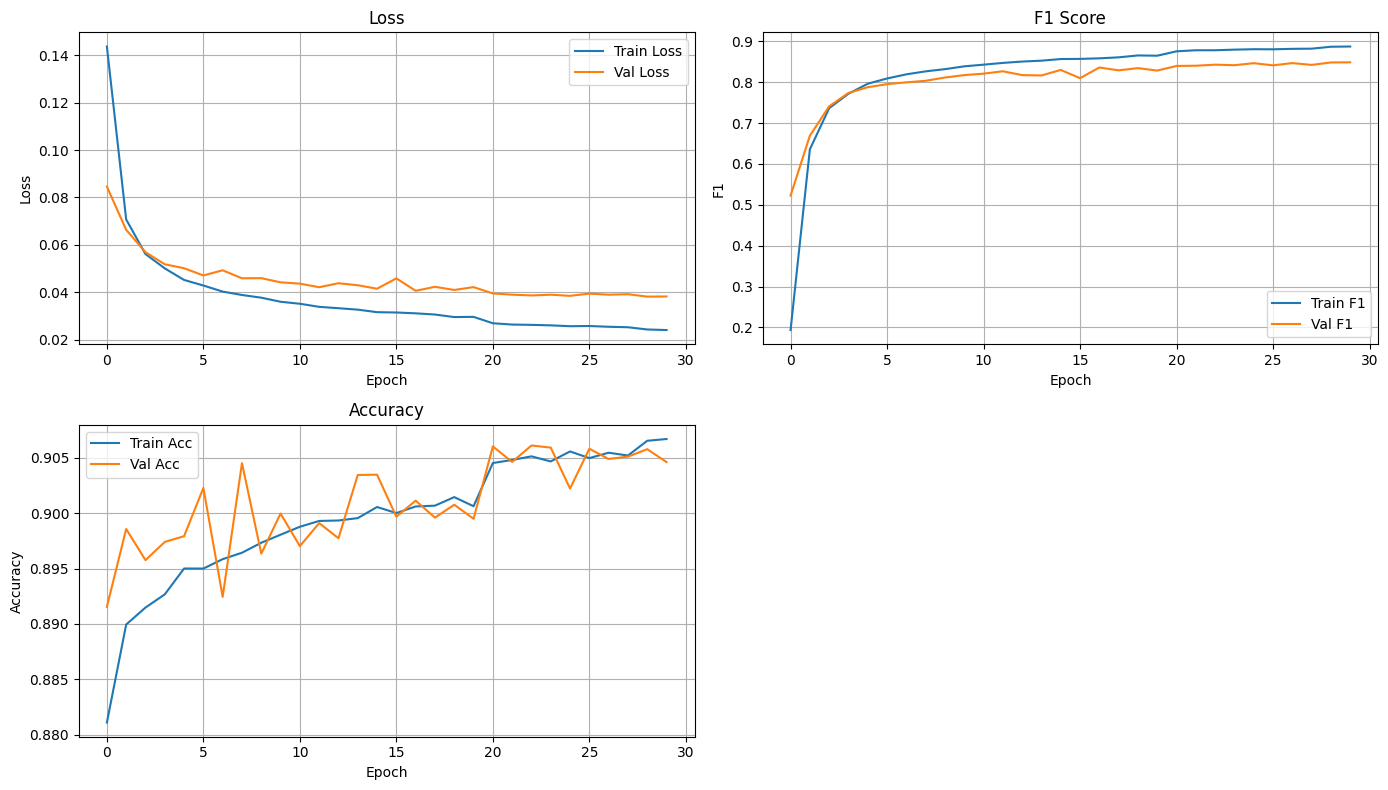

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# 🔵 1. Train vs Val Loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 🟢 2. Train vs Val F1
plt.subplot(2, 2, 2)
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Val F1')
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.grid(True)

# 🟡 3. Train vs Val Accuracy
plt.subplot(2, 2, 3)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Pitch Eval**

In [55]:
# Yeni liste toplama (reshape ederek)
y_true_val = []
y_pred_val = []

with torch.no_grad():
    for mel, label in val_loader:
        mel, label = mel.to(device), label.to(device)
        output = model(mel)
        preds = (torch.sigmoid(output) > 0.5).int().cpu().numpy()
        label_np = label.cpu().int().numpy()

        # ✅ Shape düzleştiriliyor: [49, T] → [T, 49]
        y_true_val.append(label_np.squeeze().T)
        y_pred_val.append(preds.squeeze().T)

# ✅ Şimdi concat edebilirsin
y_true_val = np.concatenate(y_true_val, axis=0)  # [n_frames, 49]
y_pred_val = np.concatenate(y_pred_val, axis=0)  # [n_frames, 49]

Support'un çok düşük olduğu pitch değerleri data augement, class weight ile dengelenebilir.

pitch değeri 30 dan küçük olan MIDI kanalları hesaplamanın dışında tutularak temiz macro f1 score elde edilebilir.

In [56]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true_val,
    y_pred_val,
    target_names=[f'MIDI_{i}' for i in range(40, 89)],
    zero_division=0
))

              precision    recall  f1-score   support

     MIDI_40       0.82      0.49      0.62      1948
     MIDI_41       0.96      0.78      0.86      2800
     MIDI_42       0.96      0.68      0.80      1667
     MIDI_43       0.90      0.61      0.73      2053
     MIDI_44       0.88      0.65      0.75      2562
     MIDI_45       0.79      0.69      0.74      2126
     MIDI_46       0.91      0.76      0.83      2544
     MIDI_47       0.87      0.75      0.81      3056
     MIDI_48       0.92      0.84      0.88      4176
     MIDI_49       0.91      0.83      0.87      3400
     MIDI_50       0.88      0.80      0.84      3378
     MIDI_51       0.91      0.83      0.87      4246
     MIDI_52       0.90      0.76      0.82      4727
     MIDI_53       0.85      0.89      0.87      5333
     MIDI_54       0.89      0.83      0.86      3434
     MIDI_55       0.91      0.79      0.85      5725
     MIDI_56       0.90      0.82      0.86      7105
     MIDI_57       0.91    

<ipython-input-59-c3b20ddb2457>:27: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


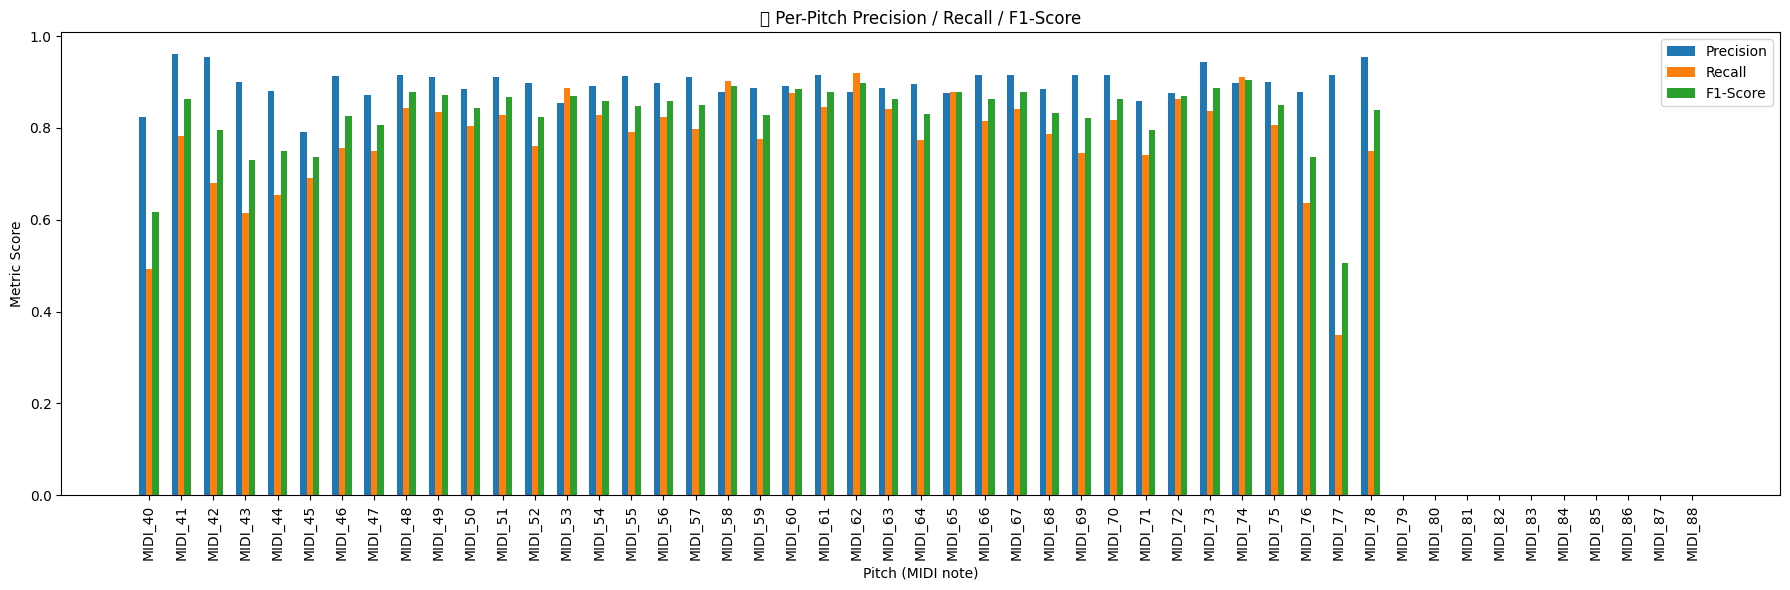

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# classification_report çıktısını al, dictionary formatında
report = classification_report(y_true_val, y_pred_val, target_names=[f'MIDI_{i}' for i in range(40, 89)], output_dict=True, zero_division=0)

# Sadece pitch'lere ait satırları al
pitches = [k for k in report.keys() if k.startswith('MIDI_')]
precisions = [report[p]['precision'] for p in pitches]
recalls = [report[p]['recall'] for p in pitches]
f1s = [report[p]['f1-score'] for p in pitches]
supports = [report[p]['support'] for p in pitches]

x = np.arange(len(pitches))  # X ekseni için pitch index

plt.figure(figsize=(18, 6))
plt.bar(x - 0.2, precisions, width=0.2, label='Precision')
plt.bar(x, recalls, width=0.2, label='Recall')
plt.bar(x + 0.2, f1s, width=0.2, label='F1-Score')

plt.xticks(x, pitches, rotation=90)
plt.xlabel("Pitch (MIDI note)")
plt.ylabel("Metric Score")
plt.title("🎯 Per-Pitch Precision / Recall / F1-Score")
plt.legend()
plt.tight_layout()
plt.show()

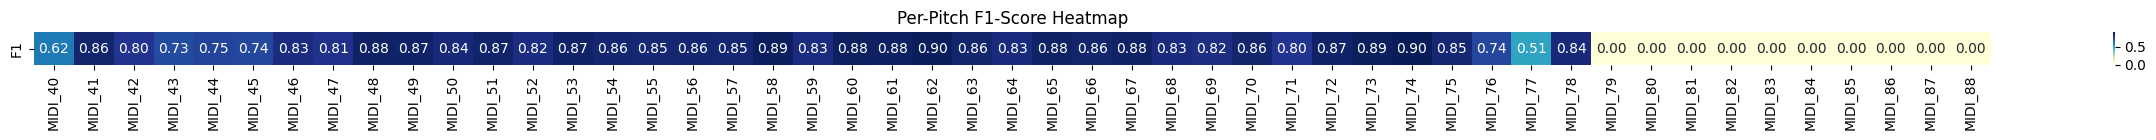

In [64]:
import seaborn as sns

plt.figure(figsize=(25, 1.5))
sns.heatmap([f1s], annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=pitches, yticklabels=["F1"], cbar=True)
plt.xticks(rotation=90)
plt.title("Per-Pitch F1-Score Heatmap")
plt.tight_layout()
plt.show()

<ipython-input-68-4197f61b76b5>:11: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


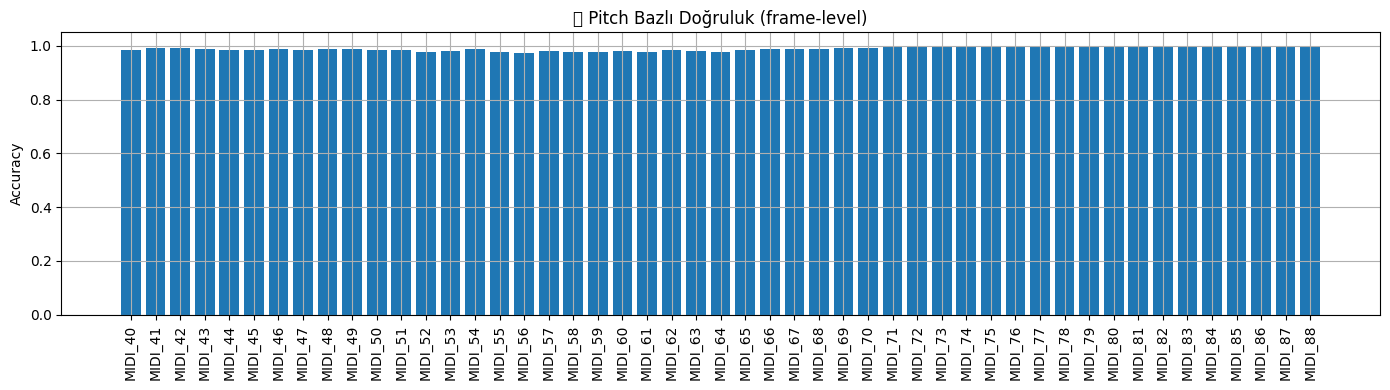

In [68]:
correct_per_pitch = (y_true_val == y_pred_val).sum(axis=0)
total_per_pitch = y_true_val.shape[0]
accuracy_per_pitch = correct_per_pitch / total_per_pitch

plt.figure(figsize=(14, 4))
plt.bar(range(49), accuracy_per_pitch)
plt.xticks(range(49), [f"MIDI_{i}" for i in range(40, 89)], rotation=90)
plt.ylabel("Accuracy")
plt.title("🎹 Pitch Bazlı Doğruluk (frame-level)")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Hamming Loss, ROC-AUC**

In [57]:
from sklearn.metrics import hamming_loss

hloss = hamming_loss(y_true_val, y_pred_val)
print(f"🧠 Hamming Loss (frame başı yanlış sınıf oranı): {hloss:.4f}")

🧠 Hamming Loss (frame başı yanlış sınıf oranı): 0.0107


### **Prediction Plot**

<ipython-input-65-c726e131e027>:26: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-65-c726e131e027>:26: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


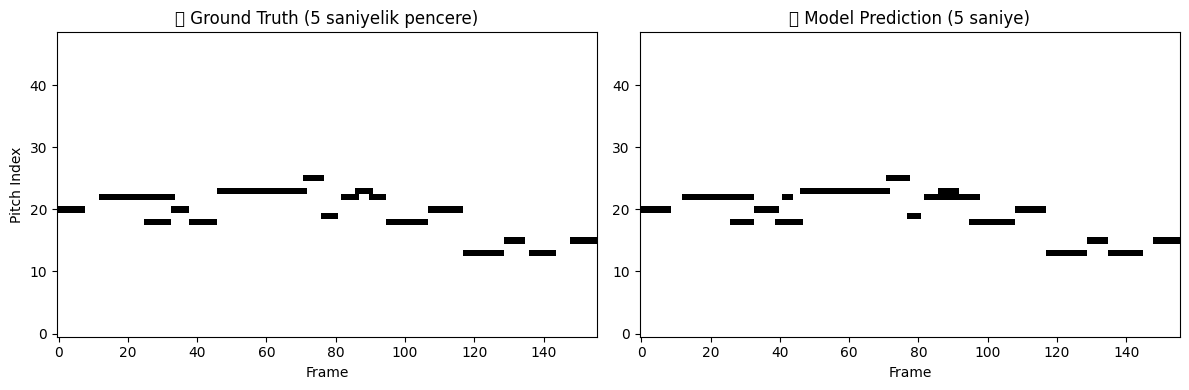

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# 1 saniye ≈ 31.25 frame (16000 / 512)
fps = 31.25
window_size = int(fps * 5)  # 5 saniyelik pencere
start = np.random.randint(0, y_true_val.shape[0] - window_size)

y_true_win = y_true_val[start:start+window_size].T
y_pred_win = y_pred_val[start:start+window_size].T

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(y_true_win, aspect='auto', cmap='gray_r', origin='lower')
plt.title("🎼 Ground Truth (5 saniyelik pencere)")
plt.ylabel("Pitch Index")
plt.xlabel("Frame")

plt.subplot(1, 2, 2)
plt.imshow(y_pred_win, aspect='auto', cmap='gray_r', origin='lower')
plt.title("🔮 Model Prediction (5 saniye)")
plt.xlabel("Frame")

plt.tight_layout()
plt.show()

### **Sound Reconstruction**

In [75]:
import numpy as np

y_pred_temp = np.concatenate(y_pred_val, axis=0)  # [T, 49]

In [84]:
import librosa

fps = 31.25
note_range = range(40, 89)  # MIDI 40–88
string_names = ['e', 'B', 'G', 'D', 'A', 'E']  # Gitar telleri (ters)
string_midi = [64, 59, 55, 50, 45, 40]

def pitch_to_string_fret(midi_pitch):
    for i, open_string in enumerate(string_midi):
        fret = midi_pitch - open_string
        if 0 <= fret <= 22:
            return i, fret  # (string_index, fret)
    return None, None

print("🪕 5 saniyelik tahminin tablature gösterimi:\n")
for t in range(int(5 * fps)):
    time = round(t / fps, 2)
    active_pitches = np.where(np.atleast_1d(y_pred_temp[t]) == 1)[0]
    tab_line = ['-' for _ in range(6)]
    for p in active_pitches:
        midi_pitch = 40 + p
        s_idx, fret = pitch_to_string_fret(midi_pitch)
        if s_idx is not None:
            tab_line[5 - s_idx] = str(fret)  # Gitar tablature ters yazılır
    print(f"{time:5.2f}s | {' '.join(tab_line)}")

🪕 5 saniyelik tahminin tablature gösterimi:

 0.00s | - - - - - -
 0.03s | - - - - - -
 0.06s | - - - - - -
 0.10s | - - - - - -
 0.13s | - - - - - -
 0.16s | - - - - - -
 0.19s | - - - - - -
 0.22s | - - - - - -
 0.26s | - - - - - -
 0.29s | - - - - - -
 0.32s | - - - - - -
 0.35s | - - - - - -
 0.38s | - - - - - -
 0.42s | - - - - - -
 0.45s | - - - - - -
 0.48s | - - - - - -
 0.51s | - - - - - -
 0.54s | - - - - - -
 0.58s | - - - - - -
 0.61s | 0 - - - - -
 0.64s | - - - - - -
 0.67s | - - - - - -
 0.70s | 0 - - - - -
 0.74s | - - - - - -
 0.77s | - - - - - -
 0.80s | - - - - - -
 0.83s | - - - - - -
 0.86s | - - - - - -
 0.90s | - - - - - -
 0.93s | - - - - - -
 0.96s | - - - - - -
 0.99s | - - - - - -
 1.02s | - - - - - -
 1.06s | - - - - - -
 1.09s | - - - - - -
 1.12s | - - - - - -
 1.15s | - - - - - -
 1.18s | - - - - - -
 1.22s | - - - - - -
 1.25s | - - - - - -
 1.28s | - - - - - -
 1.31s | - - - - - -
 1.34s | - - - - - -
 1.38s | - - - - - -
 1.41s | - - - - - -
 1.44s | -

### **Show Model Output in Text Format**

In [73]:
import librosa
import numpy as np

fps = 31.25  # Frame per second
note_lines = []

# Geçici birleştirme: [n_examples] → [T, 49]
y_pred_temp = np.concatenate(y_pred_val, axis=0)

for t in range(y_pred_temp.shape[0]):
    active_pitches = np.where(y_pred_temp[t] == 1)[0]
    if len(active_pitches) == 0:
        continue
    notes = [librosa.midi_to_note(40 + i) for i in active_pitches]
    time = round(t / fps, 2)
    line = f"{time:>6.2f}s → 🎵 Notes: {', '.join(notes)}"
    note_lines.append(line)

# İlk 30 satırı göster
for line in note_lines[:30]:
    print(line)

<ipython-input-73-d2f6b1aa34b5>:11: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  active_pitches = np.where(y_pred_temp[t] == 1)[0]


  0.61s → 🎵 Notes: E2
  0.70s → 🎵 Notes: E2
  2.18s → 🎵 Notes: E2
  2.27s → 🎵 Notes: E2
  3.74s → 🎵 Notes: E2
  3.84s → 🎵 Notes: E2
  5.31s → 🎵 Notes: E2
  5.41s → 🎵 Notes: E2
  6.88s → 🎵 Notes: E2
  6.98s → 🎵 Notes: E2
  8.45s → 🎵 Notes: E2
  8.54s → 🎵 Notes: E2
 10.02s → 🎵 Notes: E2
 10.11s → 🎵 Notes: E2
 11.58s → 🎵 Notes: E2
 11.68s → 🎵 Notes: E2
 13.15s → 🎵 Notes: E2
 13.25s → 🎵 Notes: E2
 14.72s → 🎵 Notes: E2
 14.82s → 🎵 Notes: E2
 16.29s → 🎵 Notes: E2
 17.86s → 🎵 Notes: E2
 19.42s → 🎵 Notes: E2
 20.99s → 🎵 Notes: E2
 22.56s → 🎵 Notes: E2
 24.13s → 🎵 Notes: E2
 25.70s → 🎵 Notes: E2
 27.26s → 🎵 Notes: E2
 28.83s → 🎵 Notes: E2
 30.40s → 🎵 Notes: E2
